In [1]:
!which python

/home/user/jfayzullaev/stellar-clustering/.venv-vis/bin/python


In [17]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import LogLocator, ScalarFormatter

In [6]:
TL_EMB = "../trustlines_node2vec_kmeans_results.csv"
TL_EDGES = "~/stellar-clustering/network/data/trustline_edges_mv.csv" 

In [7]:
tl_df = pd.read_csv(TL_EMB, usecols=["account_id", "kmeans_10"])
tl_df["account_id"] = tl_df["account_id"].astype("int64")

In [8]:
edges = pd.read_csv(TL_EDGES, usecols=["account_id", "issuer_id", "asset_code", "balance"])
edges["account_id"] = edges["account_id"].astype("int64")
edges["asset_node"] = edges["issuer_id"].astype(str) + ":" + edges["asset_code"].astype(str)


In [10]:
G_tl = nx.Graph()
G_tl.add_edges_from(zip(edges["account_id"], edges["asset_node"]))
del edges 

## Top-5 clusters

In [11]:
def top5_sizes(df, kcol):
    total = len(df)
    s = (df[kcol]
         .value_counts()
         .rename_axis("cluster_id")
         .reset_index(name="n_accounts")
         .sort_values("n_accounts", ascending=False)
         .head(5))
    s["pct_of_all"] = (s["n_accounts"] / total * 100).round(2)
    s.insert(0, "k", int(kcol.split("_")[1]))
    return s

In [12]:
def per_cluster_stats(df, kcol, G, top_ids):
    rows = []
    nodes_in_G = set(G.nodes)
    total = len(df)
    for cid in top_ids:
        comm_nodes = set(df.loc[df[kcol] == cid, "account_id"])
        S = (comm_nodes & nodes_in_G)
        N = set(u for v in S for u in G.neighbors(v))
        sub = G.subgraph(S | N).copy()
        n_nodes = len(S)
        n_edges = sub.number_of_edges()
        density = (n_edges / (len(S) * len(N))) if (len(S) > 0 and len(N) > 0) else 0.0

        avg_degree = (sum(dict(sub.degree(S)).values()) / len(S)) if len(S) > 0 else 0.0

        rows.append({
            "k": int(kcol.split("_")[1]),
            "cluster_id": cid,
            "size_in_partition": len(comm_nodes),
            "size_in_graph": n_nodes,
            "edges_in_graph": n_edges,
            "density": density,
            "avg_degree": avg_degree,
            "pct_of_all_nodes": round(len(comm_nodes) / total * 100, 2),
        })
    return pd.DataFrame(rows).sort_values("size_in_graph", ascending=False)

In [13]:
tl_top10 = top5_sizes(tl_df, "kmeans_10")

print("Trustlines — Top 5 clusters (k=10):")
display(tl_top10)

Trustlines — Top 5 clusters (k=10):


,k,cluster_id,n_accounts,pct_of_all
0,10,0,5413,22.02
1,10,3,3418,13.90
2,10,1,3331,13.55
3,10,7,2988,12.15
4,10,6,1979,8.05


In [14]:
tl_top10_stats = per_cluster_stats(tl_df, "kmeans_10", G_tl, tl_top10["cluster_id"].tolist())

print("Trustlines — Per-cluster stats for Top 5 (k=10):")
display(tl_top10_stats)


Trustlines — Per-cluster stats for Top 5 (k=10):


,k,cluster_id,size_in_partition,size_in_graph,edges_in_graph,density,avg_degree,pct_of_all_nodes
0,10,0,5413,5413,901435,0.006341,166.531498,22.02
1,10,3,3418,3418,1749773,0.012925,511.928906,13.90
2,10,1,3331,3331,1027960,0.006885,308.604023,13.55
3,10,7,2988,2988,237404,0.002027,79.452477,12.15
4,10,6,1979,1979,487864,0.007171,246.520465,8.05


Large groups (20–25k accounts) where almost every account has degree = 0 (no transactions inside).

### Plot the Degree Distribution for top 5 

In [ ]:
def plot_trustline_hist_for_top5(G, df, top_table, kcol, bins=50):
    nodes_in_G = set(G.nodes)

    for cid in top_table["cluster_id"]:
        S = set(df.loc[df[kcol] == cid, "account_id"]) & nodes_in_G
        if not S:
            continue

        degs = [G.degree(v) for v in S]
        if not degs:
            continue

        degs = np.array(degs)
        n = len(degs)
        median_deg = np.median(degs)
        mean_deg = np.mean(degs)

        fig, ax = plt.subplots(figsize=(6.5, 4.2))

        # histogram
        ax.hist(degs, bins=bins, edgecolor="black", alpha=0.75)
        ax.set_yscale("log")
        ax.yaxis.set_major_locator(LogLocator(base=10))
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.grid(axis="y", which="both", linestyle="--", alpha=0.4)

        ax.axvline(median_deg, linestyle="--", linewidth=1.2)
        ax.text(
            median_deg,
            ax.get_ylim()[1],
            f" median={median_deg:.0f}",
            va="top",
            ha="left",
            fontsize=8,
        )

        ax.set_xlabel("Trustlines per account")
        ax.set_ylabel("Count (log scale)")
        ax.set_title(
            f"Trustline degree distribution — {kcol} cluster {cid} (n={n})",
            fontsize=11,
        )

        fig.tight_layout()
        plt.show()

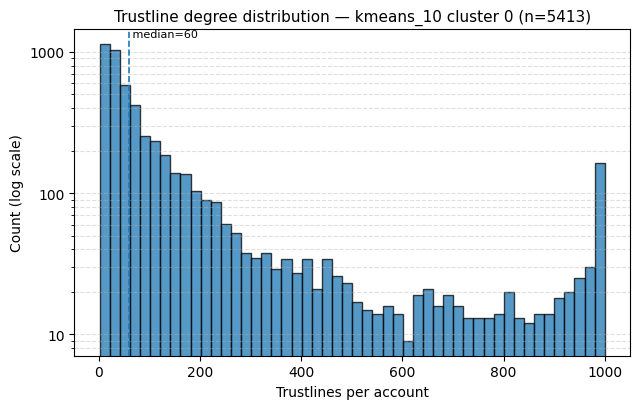

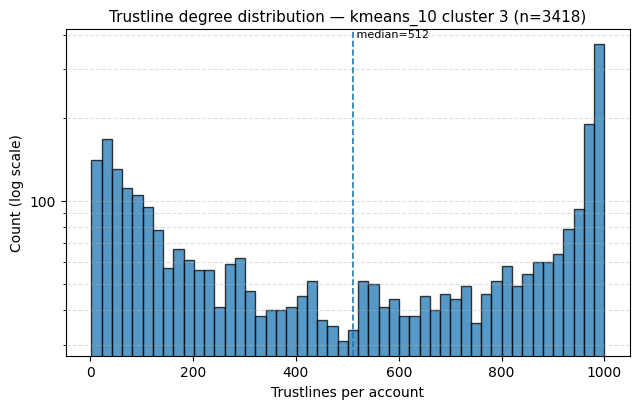

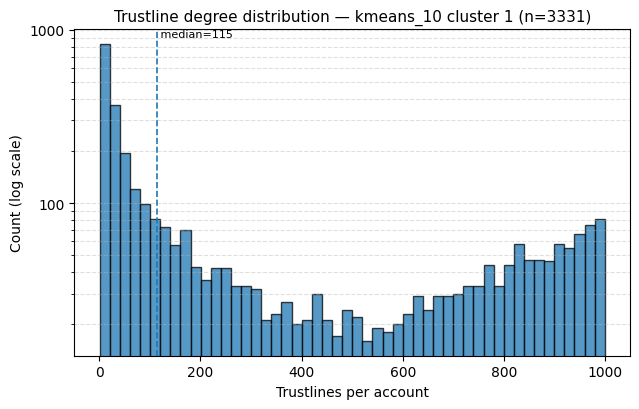

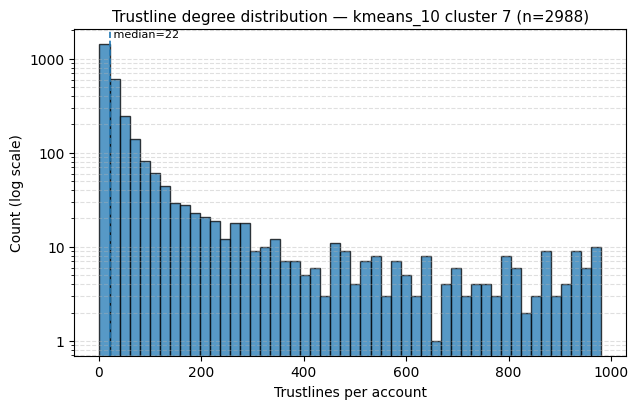

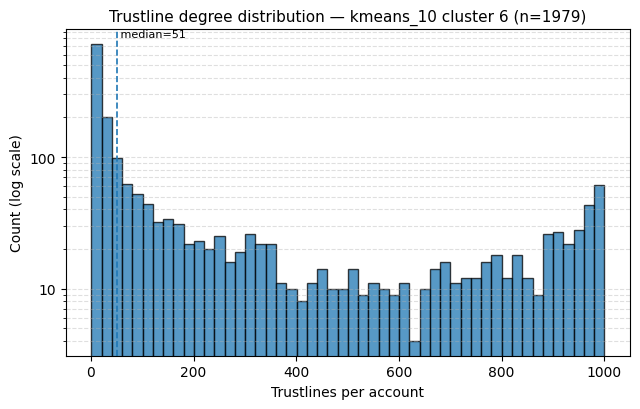

In [18]:

plot_trustline_hist_for_top5(G_tl, tl_df, tl_top10, "kmeans_10", bins=50)



### Bind to metadata

In [36]:
NODES_CSV   = "~/stellar-clustering/network/data/new/account_nodes_all_mv.csv"
FEATS_CSV   = "~/stellar-clustering/network/data/new/account_node_features_full_mv.csv"

In [38]:
assert {"account_id","kmeans_10"}.issubset(tl_df.columns)

In [39]:
df_nodes = pd.read_csv(NODES_CSV)                     
df_meta  = pd.read_csv(FEATS_CSV)  

In [40]:
tl_df["account_id"] = tl_df["account_id"].astype("int64", errors="ignore")
if "account_id" in df_nodes.columns:
    df_nodes["account_id"] = df_nodes["account_id"].astype("int64", errors="ignore")
df_meta["account_id"] = df_meta["account_id"].astype("int64", errors="ignore")

In [42]:
df_comm = tl_df[["account_id","kmeans_10"]].copy()

In [43]:
df_merged = df_comm.merge(df_meta, on="account_id", how="left")

In [46]:
overlap = df_comm["account_id"].isin(df_meta["account_id"]).sum()
print(f"Matched account IDs: {overlap} / {len(df_comm)}")

Matched account IDs: 24586 / 24586


In [47]:
df_merged.to_csv("tl_kmeans_with_metadata.csv", index=False)
print("Saved: tl_kmeans_with_metadata.csv")

Saved: tl_kmeans_with_metadata.csv


In [48]:
df_with_metadata = df_merged[df_merged["address"].notna()].copy()


### Bind with the normalized labels

In [50]:
NORM_LABELS = "../../../labled-data/labels/label-normalization/labels_entities_normalized.csv"

In [51]:
df_norm = (pd.read_csv(NORM_LABELS, usecols=["account_id","name"])
             .dropna(subset=["account_id","name"])
             .drop_duplicates(subset=["account_id"])
             .rename(columns={"name":"entity"}))

In [52]:
for col in ["account_id"]:
    try:
        tl_df[col] = tl_df[col].astype("Int64")
        df_norm[col] = df_norm[col].astype("Int64")
    except Exception:
        tl_df[col] = tl_df[col].astype(str)
        df_norm[col] = df_norm[col].astype(str)


In [ ]:
def bind_and_plot(tx_df, df_norm, kcol, topn=10):
    df_comm = tx_df[["account_id", kcol]].copy()
    df_matched = df_comm.merge(df_norm, on="account_id", how="inner")
    print(f"[{kcol}] Matched normalized-labeled accounts: {len(df_matched):,} / {len(df_comm):,} "
          f"({len(df_matched)/len(df_comm):.2%})")

    counts = (df_matched[kcol].value_counts().head(topn).sort_values(ascending=True))
    plt.figure(figsize=(7,4))
    counts.plot(kind="barh", title=f"TX {kcol}: Top clusters by # normalized-labeled accounts")
    plt.xlabel("Number of Labeled Accounts"); plt.ylabel("Cluster ID")
    plt.tight_layout(); plt.show()

    return df_matched

[kmeans_10] Matched normalized-labeled accounts: 139 / 24,586 (0.57%)


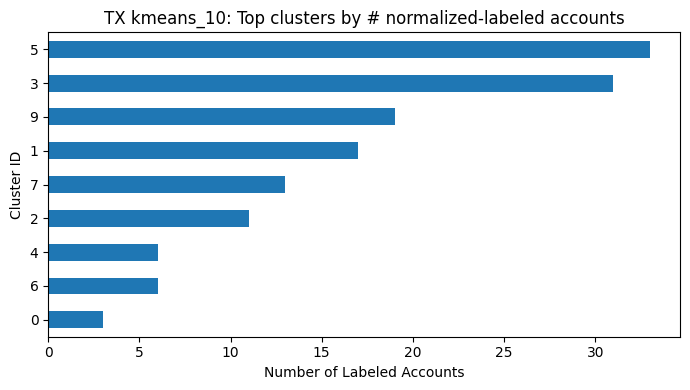

In [55]:
tl_matched_k10 = bind_and_plot(tl_df, df_norm, "kmeans_10", topn=10)

entity breakdown 

In [ ]:
def entity_breakdown(df_matched, kcol, topn=5):

    label_counts = (
        df_matched.groupby([kcol, "entity"])
        .size()
        .reset_index(name="count")
    )

    top_clusters = (
        label_counts.groupby(kcol)["count"]
        .sum()
        .sort_values(ascending=False)
        .head(topn)
        .index
        .tolist()
    )
    for cid in top_clusters:
        print(f"\nCluster {cid} — {kcol} — normalized entity breakdown:")
        sub = label_counts[label_counts[kcol] == cid].copy()
        sub["share"] = (sub["count"] / sub["count"].sum()).round(3)
        display(sub.sort_values("count", ascending=False))

In [58]:
entity_breakdown(tl_matched_k10, "kmeans_10", topn=5)


Cluster 5 — kmeans_10 — normalized entity breakdown:


,kmeans_10,entity,count,share
12,5,SCAM,33,1.0



Cluster 3 — kmeans_10 — normalized entity breakdown:


,kmeans_10,entity,count,share
10,3,SCAM,30,0.968
9,3,CEX.IO,1,0.032



Cluster 9 — kmeans_10 — normalized entity breakdown:


,kmeans_10,entity,count,share
24,9,SCAM,18,0.947
25,9,TMM bot,1,0.053



Cluster 1 — kmeans_10 — normalized entity breakdown:


,kmeans_10,entity,count,share
7,1,SCAM,10,0.588
6,1,Lobstr,2,0.118
1,1,Bitfinex,1,0.059
3,1,GateIO,1,0.059
2,1,Bitmart,1,0.059
5,1,HitBTC,1,0.059
4,1,GoodX,1,0.059



Cluster 7 — kmeans_10 — normalized entity breakdown:


,kmeans_10,entity,count,share
21,7,SCAM,6,0.462
16,7,Centre,1,0.077
18,7,KuCoin,1,0.077
17,7,IndoDax,1,0.077
19,7,MEXC,1,0.077
20,7,Mercado Bitcoin,1,0.077
22,7,TMM bot,1,0.077
23,7,montelibero.org,1,0.077
